# Natural language processing with IMDB dataset

* IMDB dataset (http://ai.stanford.edu/~amaas/data/sentiment/): Movie review sentences classified as positive or negative. 25,000 traning set, and 25,000 testing set.
* Word embedding for mapping words with smentics in a higher dimensional space
* Flattening vs Global average pooling

## Download IMDB dataset

In [1]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [2]:
tf.enable_eager_execution()

In [4]:
import tensorflow_datasets as tfds

In [5]:
imdb, info = tfds.load("imdb_reviews",with_info=True,as_supervised=True)

W0803 20:45:45.843845 140734868047296 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


## Tokenizing the dataset

* Classification for training and testing data set

In [11]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

# Training
training_sentences = []
training_labels = []

# Testing/Validation
testing_sentences = []
testing_labels = []

# S and l is originally in tf.Tensor format, converting them to numpy arrays
for s,l in train_data:
    training_sentences.append(str(s.numpy())) 
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

* Tokenizing both training and testing set
* Padding the sequences to the same length

In [51]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Creating tokenizer with training sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# Word-index and Index-word dictionaries
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# Training padded sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Testing padded sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

## Building neural network with word embedding and flatteing

* NN with word embedding to the 16 dimensional space

In [22]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


* Traning

In [23]:
num_epochs = 10
history1 = model1.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 5s 183us/sample - loss: 0.5034 - acc: 0.7351 - val_loss: 0.3457 - val_acc: 0.8495

* Plotting traning history
* As it can be seen, traning accuracy can be up to 1.0.
* On the other hand, validation accuracy does not increase with traning, while the validation loss continuously increases, indicating the decrease in the prediction confidence, indicating overfitting.

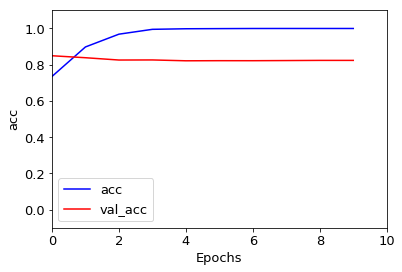

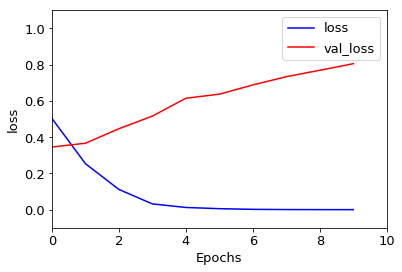

In [43]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    font = 13
    plt.plot(history.history[string],'b')
    plt.plot(history.history['val_'+string],'r')
    plt.xlabel("Epochs", fontsize=font)
    plt.ylabel(string, fontsize=font)
    plt.legend([string, 'val_'+string], fontsize=font)
    plt.xlim([0,num_epochs])
    plt.ylim([-0.1,1.1])
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.show()

plot_graphs(history1, "acc")
plot_graphs(history1, "loss")

## Building neural network with word embedding and global average pooling

* This time, I build and train the NN with global average pooling.
* GAP can reduce the risk of overfitting by reducing the total number of parameters in the model, just like what drop out layers does.

In [48]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 102       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [49]:
num_epochs = 10
history2 = model2.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 135us/sample - loss: 0.5670 - acc: 0.7470 - val_loss: 0.4079 - val_acc: 0.8378

* Plotting training history
* The validation accuracy still does not increases, and the validation loss is also still slightly increasing, but with much lower rate.

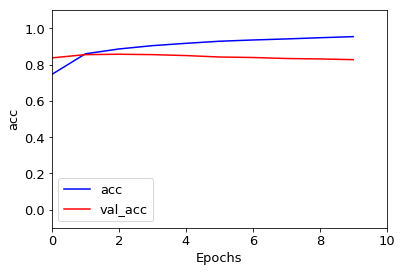

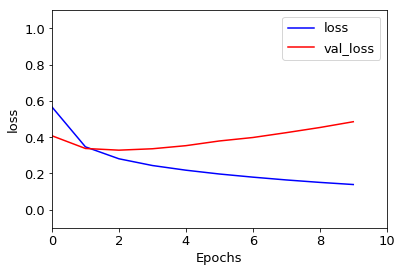

In [50]:
plot_graphs(history2, "acc")
plot_graphs(history2, "loss")